In [1]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import pathlib

In [2]:
# train_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-train/left/')
# test_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-test/left/')
# train_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-train-v4/left/')
# test_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-test-v2/left/')
train_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/augmented/usual_colors/hei-train-v1/left/')
test_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/augmented/usual_colors/hei-test-v1/left/')

In [3]:
images = list(train_folder_path.glob('*/*.jpg'))
image_count = len(images)
print(image_count)

145


(128, 128)


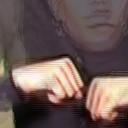

In [4]:
abitare = list(train_folder_path.glob('abitare/*'))
image = PIL.Image.open(str(abitare[0]))
print(image.size)
image

(102, 102)


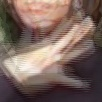

In [5]:
acqua = list(train_folder_path.glob('*acqua/*'))
image = PIL.Image.open(str(acqua[1]))
print(image.size)
image

In [6]:
images_sizes = [PIL.Image.open(image).size[0] for image in images]
images_sizes[:10]

[108, 108, 90, 100, 70, 62, 62, 60, 84, 96]

In [7]:
min(images_sizes)

46

In [8]:
video_shape = (576, 720)
video_area = video_shape[0]*video_shape[1]
images_areas = np.square(images_sizes)

In [9]:
area_ratio = np.round(images_areas/video_area, 3)
average_ratio = np.round(np.mean(area_ratio), 3)
average_ratio

0.021

In [10]:
np.round(np.mean(images_sizes))

92.0

In [11]:
train_batch_size = 32
img_height = 104
img_width = 104

In [12]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  train_folder_path,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

Found 145 files belonging to 10 classes.
Using 116 files for training.
Using 29 files for validation.


In [10]:
train_ds= tf.keras.utils.image_dataset_from_directory(
  train_folder_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

Found 231 files belonging to 10 classes.


In [13]:
class_names = train_ds.class_names

In [14]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_folder_path,
  image_size=(img_height, img_width),
  batch_size=100)

Found 79 files belonging to 10 classes.


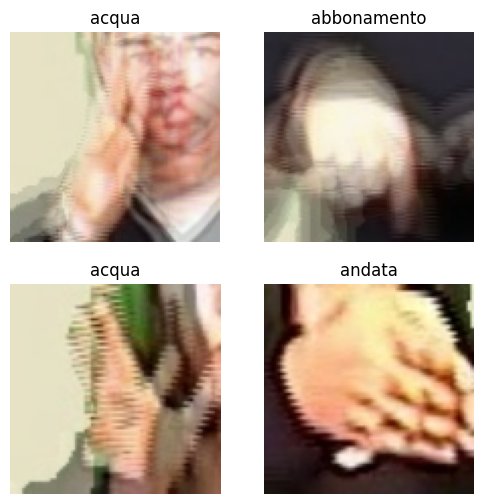

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

8.916056 254.82138


In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [18]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
num_classes = 10

In [33]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [38]:
alexnet = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu'),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [34]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [39]:
alexnet.compile(
    optimizer='sgd',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']    
)

In [35]:
model.fit(
  train_ds,
  epochs=15,
  validation_data=val_ds
)

Epoch 1/15
4/4 [==============================] - 1s 194ms/step - loss: 2.3036 - accuracy: 0.1207 - val_loss: 2.2321 - val_accuracy: 0.1034
Epoch 2/15
4/4 [==============================] - 1s 154ms/step - loss: 2.1574 - accuracy: 0.2155 - val_loss: 2.0930 - val_accuracy: 0.2759
Epoch 3/15
4/4 [==============================] - 1s 159ms/step - loss: 1.8758 - accuracy: 0.3966 - val_loss: 1.6891 - val_accuracy: 0.5862
Epoch 4/15
4/4 [==============================] - 1s 161ms/step - loss: 1.3111 - accuracy: 0.6897 - val_loss: 1.2098 - val_accuracy: 0.6207
Epoch 5/15
4/4 [==============================] - 1s 164ms/step - loss: 0.8345 - accuracy: 0.7155 - val_loss: 0.8508 - val_accuracy: 0.7931
Epoch 6/15
4/4 [==============================] - 1s 157ms/step - loss: 0.6577 - accuracy: 0.7586 - val_loss: 0.6761 - val_accuracy: 0.8276
Epoch 7/15
4/4 [==============================] - 1s 161ms/step - loss: 0.4022 - accuracy: 0.9052 - val_loss: 0.5648 - val_accuracy: 0.7931
Epoch 8/15
4/4 [====

In [40]:
import math
# Define configuration parameters
start_lr = 0.005
rampup_epochs = 10
exp_decay = 0.1

# Define the scheduling function
def schedule(epoch):
  def lr(epoch, start_lr, rampup_epochs, exp_decay):
    if epoch < rampup_epochs:
      return start_lr
    else:
      return start_lr * math.exp(-exp_decay * epoch)
  return lr(epoch, start_lr, rampup_epochs, exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=True)


alexnet.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[lr_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/50


d:\Documentos\Polito\Thesis\Code\sign-language-recognition\thesis-venv\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


6/6 [==============================] - 8s 1s/step - loss: 2.3027 - accuracy: 0.0919 - val_loss: 2.3025 - val_accuracy: 0.0435 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.005.
Epoch 2/50
6/6 [==============================] - 6s 1s/step - loss: 2.3013 - accuracy: 0.0919 - val_loss: 2.3031 - val_accuracy: 0.0652 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.005.
Epoch 3/50
6/6 [==============================] - 6s 1s/step - loss: 2.3006 - accuracy: 0.1297 - val_loss: 2.3037 - val_accuracy: 0.1087 - lr: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.005.
Epoch 4/50
6/6 [==============================] - 6s 1s/step - loss: 2.2998 - accuracy: 0.1459 - val_loss: 2.3043 - val_accuracy: 0.0870 - lr: 0.0050

Epoch 5: LearningRateScheduler setting learning rate to 0.005.
Epoch 5/50
6/6 [==============================] - 7s 1s/step - loss: 2.3004 - accuracy: 0.1459 - val_loss: 2.3050 - val_accuracy: 0.0870 - lr: 0.0050

Epoc

KeyboardInterrupt: 

In [96]:
len(test_ds)

1

In [94]:
class_names

['abbonamento',
 'abitare',
 'acqua',
 'affitto',
 'allegare',
 'allergia',
 'ambulanza',
 'amministrazione',
 'ancona',
 'andata']

In [36]:
x, y = next(iter(test_ds))
predictions = np.argmax(model.predict(x), axis=-1)
labels = y

m = tf.keras.metrics.Accuracy()
m.update_state(predictions, labels)
m.result().numpy()

3/3 [==============================] - 0s 26ms/step


0.5316456

In [25]:
model.save("./saved_models/trainset_v4")

INFO:tensorflow:Assets written to: ./saved_models/trainset_v4\assets


INFO:tensorflow:Assets written to: ./saved_models/trainset_v4\assets


Label: abbonamento
Prediction: allergia


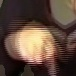




Label: abbonamento
Prediction: allergia


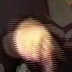




Label: abbonamento
Prediction: allergia


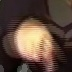




Label: abbonamento
Prediction: allergia


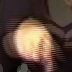




Label: abbonamento
Prediction: allergia


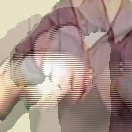




Label: abbonamento
Prediction: ambulanza


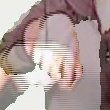




Label: abbonamento
Prediction: allergia


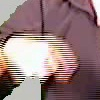




Label: abitare
Prediction: abitare


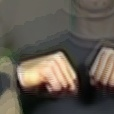




Label: abitare
Prediction: allergia


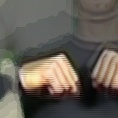




Label: abitare
Prediction: allergia


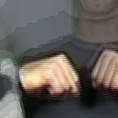




Label: abitare
Prediction: abitare


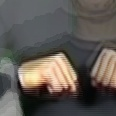




Label: abitare
Prediction: allergia


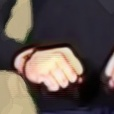




Label: abitare
Prediction: allergia


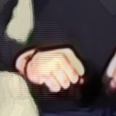




Label: abitare
Prediction: allergia


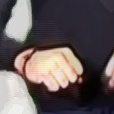




Label: abitare
Prediction: allergia


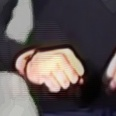




Label: acqua
Prediction: acqua


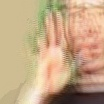




Label: acqua
Prediction: acqua


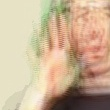




Label: acqua
Prediction: acqua


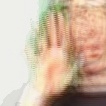




Label: acqua
Prediction: acqua


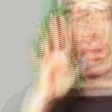




Label: acqua
Prediction: ambulanza


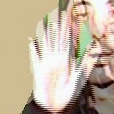




Label: acqua
Prediction: ambulanza


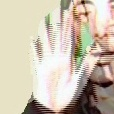




Label: acqua
Prediction: ambulanza


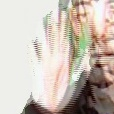




Label: acqua
Prediction: ambulanza


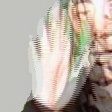




Label: affitto
Prediction: affitto


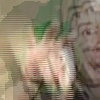




Label: affitto
Prediction: affitto


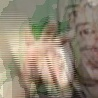




Label: affitto
Prediction: affitto


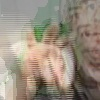




Label: affitto
Prediction: affitto


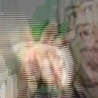




Label: affitto
Prediction: abbonamento


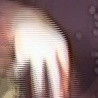




Label: affitto
Prediction: abbonamento


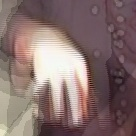




Label: affitto
Prediction: allergia


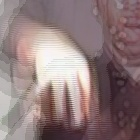




Label: affitto
Prediction: abbonamento


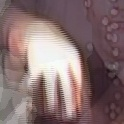




Label: allegare
Prediction: allergia


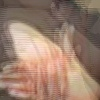




Label: allegare
Prediction: allegare


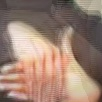




Label: allegare
Prediction: allegare


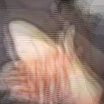




Label: allegare
Prediction: allegare


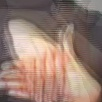




Label: allegare
Prediction: allegare


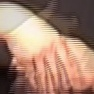




Label: allegare
Prediction: allegare


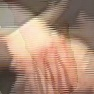




Label: allegare
Prediction: allegare


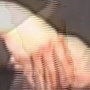




Label: allegare
Prediction: allegare


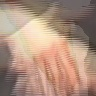




Label: allergia
Prediction: abbonamento


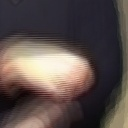




Label: allergia
Prediction: abbonamento


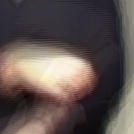




Label: allergia
Prediction: abbonamento


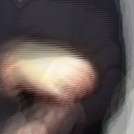




Label: allergia
Prediction: abbonamento


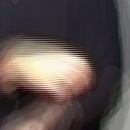




Label: allergia
Prediction: allergia


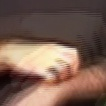




Label: allergia
Prediction: allergia


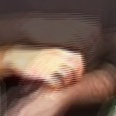




Label: allergia
Prediction: allergia


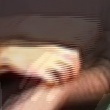




Label: allergia
Prediction: allergia


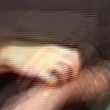




Label: ambulanza
Prediction: ambulanza


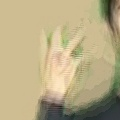




Label: ambulanza
Prediction: ambulanza


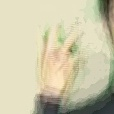




Label: ambulanza
Prediction: ambulanza


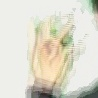




Label: ambulanza
Prediction: ambulanza


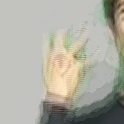




Label: ambulanza
Prediction: ambulanza


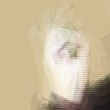




Label: ambulanza
Prediction: ambulanza


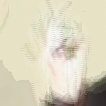




Label: ambulanza
Prediction: ambulanza


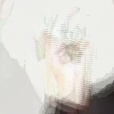




Label: ambulanza
Prediction: ambulanza


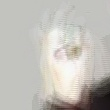




Label: amministrazione
Prediction: amministrazione


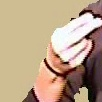




Label: amministrazione
Prediction: andata


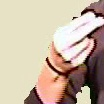




Label: amministrazione
Prediction: acqua


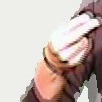




Label: amministrazione
Prediction: amministrazione


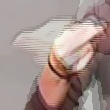




Label: amministrazione
Prediction: amministrazione


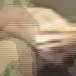




Label: amministrazione
Prediction: amministrazione


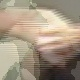




Label: amministrazione
Prediction: amministrazione


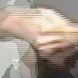




Label: amministrazione
Prediction: amministrazione


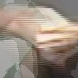




Label: ancona
Prediction: ancona


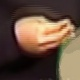




Label: ancona
Prediction: ancona


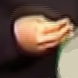




Label: ancona
Prediction: ancona


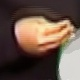




Label: ancona
Prediction: ancona


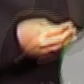




Label: ancona
Prediction: ancona


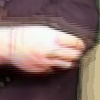




Label: ancona
Prediction: ancona


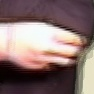




Label: ancona
Prediction: ancona


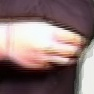




Label: ancona
Prediction: ancona


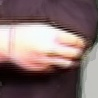




Label: andata
Prediction: amministrazione


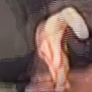




Label: andata
Prediction: amministrazione


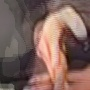




Label: andata
Prediction: amministrazione


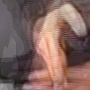




Label: andata
Prediction: amministrazione


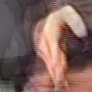




Label: andata
Prediction: allergia


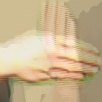




Label: andata
Prediction: ambulanza


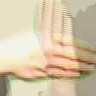




Label: andata
Prediction: ambulanza


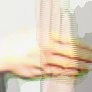




Label: andata
Prediction: ambulanza


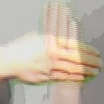

In [37]:
for path in test_folder_path.iterdir():
    for file in path.iterdir():
        print(f'Label: {path.name}')
        image = PIL.Image.open(file)
        image_array = tf.image.resize(image, [104,104])
        image_array = np.expand_dims(image_array, axis=0)
        print(f'Prediction: {class_names[int(np.argmax(model.predict(image_array, verbose=0)))]}')
        display(image)
        print('\n\n')


In [15]:
import cv2
import sys
sys.path.insert(1, './hand-tracking')
import handtracker

In [21]:
cap = cv2.VideoCapture(0)
tracker = handtracker.HandTracker(hei_frame_step=2, hei_max_duration=2, hei_overlap=0)
success = True
normalization_layer = tf.keras.layers.Rescaling(1./255)

while success == True:
    success, image = cap.read()
    if success:
        tracker.tracking(image, subpixel_layout='BGR')         

        hei_left, hei_right = tracker.image_averaging(save=False)
        if len(hei_left) > 0:
            print("Check")
            hei_left = tf.image.resize(hei_left, [104,104])
            hei_left = np.expand_dims(hei_left, axis=0)
            print(f'Prediction: {class_names[int(np.argmax(model.predict(hei_left, verbose=0)))]}')

Check
Prediction: andata
Check
Prediction: andata
Check
Prediction: andata
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: amministrazione
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare


KeyboardInterrupt: 

In [22]:
cap.release()

In [26]:
class_names

['abbonamento',
 'abitare',
 'acqua',
 'affitto',
 'allegare',
 'allergia',
 'ambulanza',
 'amministrazione',
 'ancona',
 'andata']